In [3]:
#基础
import numpy as np
import pandas as pd

#绘图
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot
%matplotlib inline

#Model
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# from SALib.sample import saltelli, sobol
# from SALib.analyze import sobol 
from SALib.analyze import sobol  # Import the correct sobol for analysis
from SALib.sample import sobol as sobol_sample  # Keep the sampling import

In [4]:
##### import data #####
housing_modified = pd.read_csv("../data/housing_modified.csv")     # housing_modified is DataFrame
x_data = housing_modified[['CRIM','ZN','INDUS','CHAS','NOX','RM','GE','DIS','RAD','TAX','PRTATIO','LSTAT']]
y_data = housing_modified[['PRICE']]
x_column_names = x_data.columns
y_column_names = y_data.columns 

In [5]:
scaler_x = StandardScaler()
scaler_x.fit(x_data)
x_data_std = pd.DataFrame(scaler_x.transform(x_data), columns=x_column_names)

scaler_y = StandardScaler()
scaler_y.fit(y_data)
y_data_std = pd.DataFrame(scaler_y.transform(y_data), columns=y_column_names)

### using standarlizated data to do sensitivity anaylse ###

In [6]:
###### Linear
# Prediction
# Establish a linear regression model and train the model with the variables.
clf = linear_model.LinearRegression()
clf.fit(x_data_std, y_data_std)

# View regression coefficients. This example is a univariate regression, so there is only one coefficient.
print('Regression parameters:', clf.coef_)

y_pred = clf.predict(x_data_std)
score = r2_score(y_data_std, y_pred)
print(score)

# Define Sensitivity model input
"""
Define model input. The Ishigami function has three inputs, x1,..., x13 where xi∈[−π,π].
In SALib, we define a dict to define the number of inputs, the names of the inputs, and the bounds for each input,
as shown below
"""
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'GE', 'DIS', 'RAD', 'TAX', 'PRTATIO', 'LSTAT', 'PRICE']
#print(boston[names[0]])
problem = {
    'num_vars': 12,
    'names': names[:-1],  # names= ['CRIM','ZN','INDUS','CHAS','NOX','RM','GE','DIS','RAD','TAX','PRTATIO','LSTAT']
    'bounds': [[x_data_std[name].min(), x_data_std[name].max()] for name in names[:-1]]  # Exclude 'PRICE' as it's the target variable
}		
# Sample generation
"""
    param_values is a NumPy matrix. If we run param_values.shape,
    we will see the matrix multiplied by features equals 8000. The Saltelli sampler generates 8000 samples.
    The Saltelli sampler generates N*(2D+2) samples, in this example, N is 1000 (the parameter we provided),
    D is 13 (the number of model inputs)
"""
# param_values = saltelli.sample(problem,1000)
param_values = sobol_sample.sample(problem, 1024)
print(type(param_values), param_values.shape)

Regression parameters: [[-0.11352809  0.11909218  0.01004589  0.07843136 -0.23633917  0.27946374
   0.01105102 -0.34131342  0.27399062 -0.23239756 -0.22068986 -0.42861343]]
0.7343070437613075
<class 'numpy.ndarray'> (26624, 12)


In [16]:
# Convert param_values to DataFrame with feature names
param_values_df = pd.DataFrame(param_values, columns=problem['names']) # need to heang to dataframe, ot there will be warning
Y = clf.predict(param_values_df).flatten()
# Run the model
# Y = evaluate(param_values)
#print(param_values.shape, Y.shape) (26624, 12) (26624,)
Si_linear_model = sobol.analyze(problem, Y, print_to_console=True)  # After obtaining the model output, calculate the sensitivity indices. 
                                                                    # Here we use sobol.analyze to calculate first-order, second-order, and total-order indices.
                                                                    # type(Si_linear_model)= <class 'SALib.util.results.ResultDict'>
# # Total-effect indices
# print('ST:', Si_linear_model['ST']) 
# # First-order indices
# print('S1:', Si_linear_model['S1']) 
# # Second-order indices
# print("x1-x2:", Si_linear_model['S2'][0, 1])
# print("x1-x3:", Si_linear_model['S2'][0, 2])
# print("x2-x3:", Si_linear_model['S2'][1, 2])
"""
    Confidence Interval: An interval estimate of a population parameter based on a sample. The confidence interval shows the degree to which the true value of this parameter is likely to fall around the measured result.
                         The confidence interval gives the credibility of the measured value of the parameter. It is generally taken as 95%, 90%, or 99%. It is a pre-determined value.
                         For example, if a candidate's support rate is 55% in an election, and the confidence interval at the 0.95 confidence level is (50%, 60%), then there is a 95% chance that the true support rate falls between 50% and 60%.
    Significance Level: A pre-determined value (generally 0.05 or 0.01), usually denoted by alpha. It is the upper bound of the probability of making a Type I error when rejecting the null hypothesis in hypothesis testing. When using the p-value test,
                        if the p-value is smaller than the significance level, the null hypothesis can be confidently rejected. Otherwise, it is not rejected.
    Confidence Level: The difference between the upper and lower limits of the confidence interval.
"""
# First-order indices: Measure the contribution of a single model input to the output variance. Second-order indices: Measure the interaction between two model inputs and their contribution to the output variance.
# Total-order indices: Measure the contribution of a model input to the output variance, including first-order and higher-order effects.

               ST   ST_conf
CRIM     0.081570  0.006989
ZN       0.015424  0.001336
INDUS    0.000094  0.000009
CHAS     0.005649  0.000438
NOX      0.058121  0.005136
RM       0.254902  0.019619
GE       0.000086  0.000008
DIS      0.187948  0.013622
RAD      0.030985  0.002635
TAX      0.030883  0.002173
PRTATIO  0.054314  0.004460
LSTAT    0.279904  0.024641
               S1   S1_conf
CRIM     0.081577  0.021125
ZN       0.015423  0.010282
INDUS    0.000095  0.000915
CHAS     0.005637  0.006617
NOX      0.058082  0.021986
RM       0.254896  0.040801
GE       0.000087  0.000823
DIS      0.187923  0.036327
RAD      0.030845  0.013724
TAX      0.031051  0.014423
PRTATIO  0.054548  0.020565
LSTAT    0.276673  0.044097
                        S2   S2_conf
(CRIM, ZN)        0.000012  0.034681
(CRIM, INDUS)     0.000012  0.034385
(CRIM, CHAS)      0.000007  0.034988
(CRIM, NOX)       0.000012  0.035952
(CRIM, RM)        0.000012  0.035006
...                    ...       ...
(RAD, PRTATIO

"\n    Confidence Interval: An interval estimate of a population parameter based on a sample. The confidence interval shows the degree to which the true value of this parameter is likely to fall around the measured result.\n                         The confidence interval gives the credibility of the measured value of the parameter. It is generally taken as 95%, 90%, or 99%. It is a pre-determined value.\n                         For example, if a candidate's support rate is 55% in an election, and the confidence interval at the 0.95 confidence level is (50%, 60%), then there is a 95% chance that the true support rate falls between 50% and 60%.\n    Significance Level: A pre-determined value (generally 0.05 or 0.01), usually denoted by alpha. It is the upper bound of the probability of making a Type I error when rejecting the null hypothesis in hypothesis testing. When using the p-value test,\n                        if the p-value is smaller than the significance level, the null hypot

3
(12, 2) <class 'pandas.core.frame.DataFrame'>


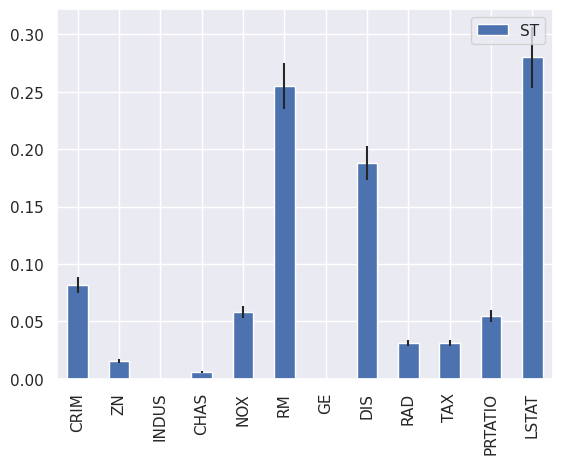

In [8]:
# Plot the results
Si_linear_model_df = Si_linear_model.to_df()
print(len(Si_linear_model_df)) # first for ST, second for S1, third for S2

print(Si_linear_model_df[0].shape, type(Si_linear_model_df[0]))
barplot(Si_linear_model_df[0])
#barplot(Si_linear_model_df[1])
#barplot(Si_linear_model_df[2])
plt.show()